# Yahoo News Text Mining Analysis


## Overview

This dataset was obtained scrapping the https://news.yahoo.com/ website and its subcategories, such as US, Politics, Originals, Health, Science and World. After obtaining the article summary and other details, the main content of the article is obtained from the article url.

We obtained a total of 904 articles, and excluding the articles with some errors in the scraping process, we end up with 762 articles.

The main features that will be analized are the text of the article, category, publisher, number of comments (comment_count).

The goal is to understand which kind of articles have a higher number of comments, and provide a description of articles that are considered negative, in regards to the type of publisher, category and common words.


In [779]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergiocarcamo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergiocarcamo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sergiocarcamo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Loading and Initial Exploration

- url: url of the article
- title: title displayed in the main page
- category_label: category displayed in the main page
- publisher: publisher displayed in the article page 
- read_time: read time obtained from the main page (in minutes)
- summary: summary of the article displayed on the main page
- author: author of the article displayed in the article page
- publish_date: date of publication displayed in the article page
- full_text: full content of the article
- comment_count: number of comments, displayed in the article page
- created_at: timestamp when the article was first scraped
- updated_at: timestamp when the article was last scraped
- title_length: length of characters of the title
- article_length: length of characters of the article
- time_since_publication: delta between publish_date and updated_at (minutes)

In [780]:
import pandas as pd

def normalize_count(count):
    # converts string counts to an integer
    if 'k' in str(count):
        try:
            count = count.replace('k', '')
            count = int(float(count) * 1000)
        except:
            pass
    return count

df = pd.read_csv('yahoo_news.csv')

cond1 = df['comment_count'].str.contains('Yahoo|English', regex=True).fillna(False)
cond2 = df['full_text'].notna()
cond3 = df['full_text']!=""

df = df[~cond1&cond2&cond3].reset_index(drop=True)

df['publish_date'] = pd.to_datetime(df['publish_date'])
df['updated_at'] = pd.to_datetime(df['updated_at'], utc=True) #.dt.tz_localize('Etc/GMT-1')
df['time_since_publication'] = ((df['updated_at'] - df['publish_date']).dt.total_seconds() / 60) #.astype(int)

df['comment_count'] = df['comment_count'].apply(normalize_count)
df['comment_count'] = pd.to_numeric(df['comment_count'], errors='coerce')

df['read_time'] = pd.to_numeric(df['read_time'].str.replace(' min read', '')).astype('Int64')

df['title_length'] = df['title'].str.len()
df['article_length'] = df['full_text'].str.len()


df = df[df['time_since_publication']>=0].reset_index(drop=True)

df.drop(columns=['tags', 'category'], inplace=True)

In [781]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   url                     896 non-null    object             
 1   title                   896 non-null    object             
 2   category_label          896 non-null    object             
 3   publisher               891 non-null    object             
 4   read_time               879 non-null    Int64              
 5   summary                 895 non-null    object             
 6   author                  896 non-null    object             
 7   publish_date            896 non-null    datetime64[ns, UTC]
 8   full_text               896 non-null    object             
 9   comment_count           882 non-null    float64            
 10  created_at              896 non-null    object             
 11  updated_at              896 non-null    datet

Looking at the median, we can observe that some of these categories have many articles with low ammount of comments. 

In [782]:
df.groupby('category_label').agg({'comment_count': 'describe', 'read_time': 'describe'}).sort_values(by=('comment_count', 'count'), ascending=False)

comment_count                                             \
                       count         mean          std  min  25%    50%   
category_label                                                            
US                     293.0   175.979522  1096.231049  0.0  0.0    0.0   
World                  106.0    88.707547   260.915384  0.0  1.0    4.5   
Politics               101.0   652.792079  1629.842657  0.0  3.0   73.0   
Celebrity               64.0   176.203125   414.728145  0.0  0.0    9.5   
Sports                  60.0   219.583333   285.758716  0.0  6.0  103.0   
Business                51.0   103.705882   357.261713  0.0  0.0    1.0   
Lifestyle               51.0    76.960784   356.896846  0.0  0.0    0.0   
Entertainment           43.0   200.116279   567.867029  0.0  0.0    1.0   
Health                  39.0   255.230769   819.871378  0.0  0.5    4.0   
Science                 22.0    11.045455    34.700730  0.0  0.0    1.0   
Opinion                 19.0  1053.263158  4137.891101  0.0  0.0    1.0   
Style                   14.0   125.857143   398.950519  0.0  0.0    0.5   
News                    10.0     3.100000     8.799621  0.0  0.0    0.0   
Technology               9.0     1.666667     2.958040  0.0  0.0    0.0   

                                read_time                                      \
                   75%      max     count      mean       std  min   25%  50%   
category_label                                                                  
US                2.00  16400.0     285.0  2.940351  3.602613  1.0   1.0  2.0   
World            29.00   1600.0     110.0  2.409091  1.823876  1.0   1.0  2.0   
Politics        596.00  11500.0     101.0   3.70297  3.195448  1.0   2.0  3.0   
Celebrity       128.25   2300.0      66.0  4.166667   3.82133  1.0   2.0  3.0   
Sports          319.00   1200.0      61.0  3.639344  2.994622  1.0   2.0  3.0   
Business         16.50   2200.0      53.0  3.037736  1.697988  1.0   2.0  3.0   
Lifestyle         6.50   2500.0      50.0      4.32  2.713835  1.0  2.25  4.0   
Entertainment    27.00   2700.0      47.0  4.404255  3.004776  1.0   2.0  3.0   
Health           19.00   4300.0      39.0  4.923077  2.813357  2.0   3.0  4.0   
Science           4.50    164.0      21.0  4.142857  1.768777  2.0   3.0  4.0   
Opinion          48.00  18100.0      19.0  3.157895  2.409775  1.0   1.5  2.0   
Style            10.00   1500.0      14.0  4.071429  2.525692  1.0   2.0  4.0   
News              0.00     28.0       4.0       3.0  2.309401  1.0   1.0  3.0   
Technology        2.00      9.0       9.0  2.333333  1.322876  1.0   1.0  2.0   

                           
                75%   max  
category_label             
US              3.0  32.0  
World           3.0  16.0  
Politics        4.0  30.0  
Celebrity       5.0  29.0  
Sports          4.0  12.0  
Business        4.0   7.0  
Lifestyle       5.0  14.0  
Entertainment   6.0  16.0  
Health          6.0  16.0  
Science         5.0   9.0  
Opinion         5.0   8.0  
Style           5.5   8.0  
News            5.0   5.0  
Technology      3.0   5.0

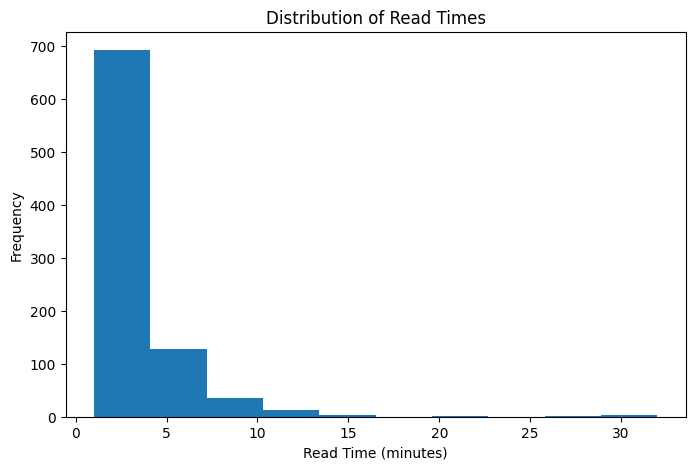

In [783]:
plt.figure(figsize=(8, 5))
plt.hist(df['read_time'], bins=10) 
plt.title('Distribution of Read Times')
plt.xlabel('Read Time (minutes)')
plt.ylabel('Frequency')
plt.show()

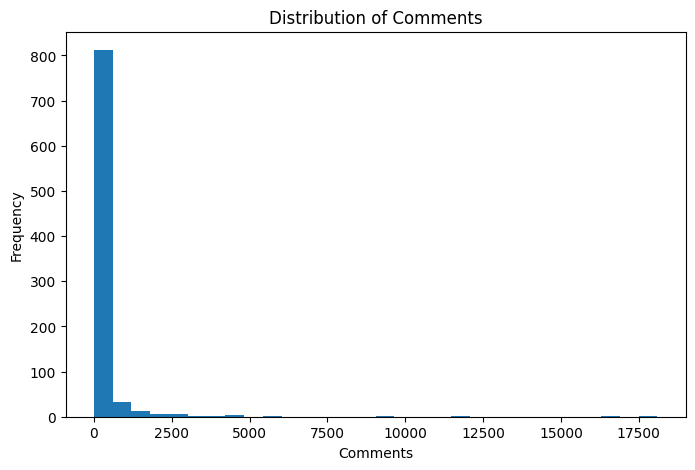

In [784]:
plt.figure(figsize=(8, 5))
plt.hist(df['comment_count'], bins=30) 
plt.title('Distribution of Comments')
plt.xlabel('Comments')
plt.ylabel('Frequency')
plt.show()

From the distribution of commnents we can see that is right skewed and most articles have 0 comments and there are some outliers with a large number of comments.

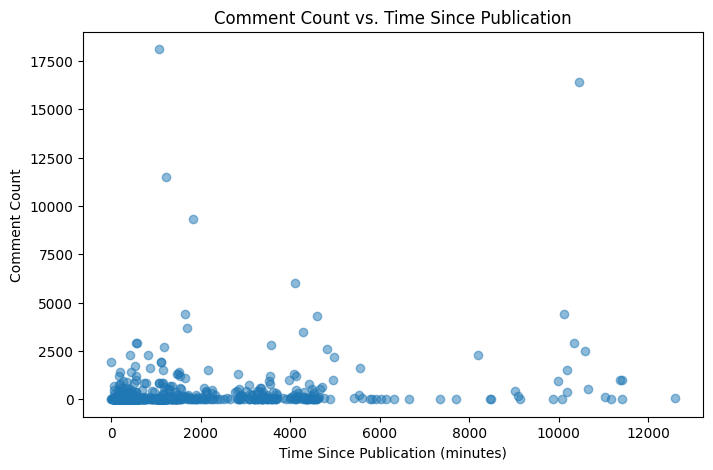

In [785]:
plt.figure(figsize=(8, 5))
plt.scatter(df['time_since_publication'], df['comment_count'], alpha=0.5)
plt.title('Comment Count vs. Time Since Publication')
plt.xlabel('Time Since Publication (minutes)')
plt.ylabel('Comment Count')
plt.show()

## Data Preprocessing

Clean and tokenize text

In [786]:
stop_words = set(stopwords.words('english'))
stop_words.update(['said', 'will', 'one', 'time'])

def clean_text(text):
    """Clean and preprocess text data"""
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        # Remove numbers and special characters
        text = re.sub(r'\d+|[—–’“”‘]+|-|\n', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        text_list = [t for t in text.split(' ') if t not in stop_words]
        text = ' '.join(text_list)

        return text
    return ''

def tokenize_text(text):
    """Tokenize text and remove stopwords"""

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply preprocessing to full_text, summary and title
df['cleaned_text'] = df['full_text'].apply(clean_text)
df['cleaned_summary'] = df['summary'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

df['tokens'] = df['cleaned_text'].apply(tokenize_text)
df['tokens_summary'] = df['cleaned_summary'].apply(tokenize_text)
df['tokens_title'] = df['cleaned_title'].apply(clean_text)


## Topic Modeling using LDA

Topic analysis is performed, to find specific topics within the defined categories, which may reflect more accurately the content of the article. Considering we have 14 categories, we start with 14 topics to see if there is a 1:1 match in topics vs categories.

In [787]:
len(df['category_label'].value_counts())

14

In [788]:
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')
tf = vectorizer.fit_transform(df['cleaned_text']).toarray()

tf_feature_names = vectorizer.get_feature_names_out()

number_of_topics = 8
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0, max_iter=50)
model.fit(tf)

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        #topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
        #                for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


# asign topics
topic_values = model.transform(tf)
df['topic'] = topic_values.argmax(axis=1)
df['topic'] =  df['topic'].astype('category')

no_top_words = 15
display_topics(model, tf_feature_names, no_top_words)


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,health,golden,trump,snow,new,like,police,season
1,also,best,president,weather,year,people,news,new
2,us,globes,election,monday,would,also,according,game
3,people,actor,biden,storm,energy,years,two,team
4,russian,film,us,inches,company,would,new,first
5,may,red,house,winter,also,get,department,coach
6,ukraine,carpet,carter,county,million,life,found,nfl
7,found,performance,donald,pm,according,even,office,yards
8,research,picture,would,service,market,says,man,win
9,russia,series,party,sunday,public,year,county,head


In [789]:
df.groupby('topic').agg({'comment_count': 'describe', 'read_time': 'describe'}).sort_values(by=('comment_count', 'count'), ascending=False)

comment_count                                                    \
              count        mean          std  min   25%   50%     75%   
topic                                                                   
2             183.0  474.049180  1531.855014  0.0  1.00  39.0  376.00   
5             163.0  250.515337  1473.070759  0.0  0.00   1.0   25.00   
6             161.0   99.490683   588.654250  0.0  0.00   0.0    2.00   
3             117.0   36.743590   198.809177  0.0  0.00   0.0    1.00   
0              75.0  138.400000   538.015523  0.0  0.00   6.0   24.50   
4              67.0  298.223881  1465.658408  0.0  0.00   1.0    6.50   
7              62.0  209.903226   284.754004  0.0  4.25  88.0  301.50   
1              54.0  183.481481   511.914857  0.0  0.00   2.5   91.75   

               read_time                                                
           max     count      mean       std  min  25%  50%  75%   max  
topic                                                                   
2      16400.0     186.0  3.478495   3.35826  1.0  2.0  3.0  4.0  31.0  
5      18100.0     166.0  4.722892  4.430783  1.0  2.0  4.0  5.0  32.0  
6       6000.0     155.0  2.116129  1.537221  1.0  1.0  2.0  2.0   9.0  
3       1900.0     112.0  2.455357  1.780214  1.0  1.0  2.0  3.0  12.0  
0       4300.0      75.0  3.226667  2.310805  1.0  2.0  3.0  4.0  16.0  
4      11500.0      67.0  3.626866  2.673301  1.0  2.0  3.0  5.0  21.0  
7       1200.0      63.0  3.603175  2.937739  1.0  2.0  3.0  4.0  12.0  
1       2700.0      55.0  4.381818   2.54217  1.0  2.0  4.0  6.0   9.0

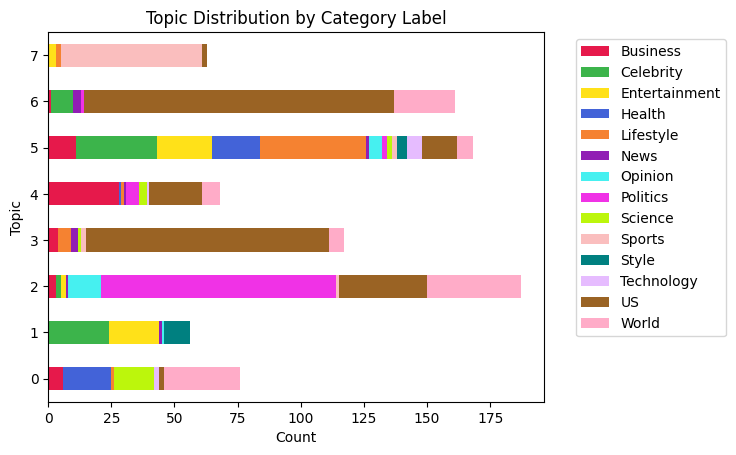

In [790]:
import pandas as pd
import matplotlib.pyplot as plt


grouped_data = df.groupby(['topic', 'category_label']).size().unstack()

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6bcff', '#9a6324', '#ffacc8']

grouped_data.plot(kind='barh', stacked=True, color=colors)

plt.xlabel("Count")
plt.ylabel("Topic")
plt.title("Topic Distribution by Category Label")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

From the top words for each topics and the plot of topic vs categories we observe some interesting topics that appear, that originally were not explicitly displayed in the categories.

- Topic 0: is about heath and the russia and Ukraine war, covered by several categories.
- Topic 1: film related topics, covered in the entertaiment and celebrity categories 
- Topic 2: related to the election, so the majority of articles are associated to politics, however, there are US and other categories that mention the same topic.
- Topic 3: is related to weather news, and we find the majority of this topic is related to US news
- Topic 4: is about sports, which is direcly related to the category
- Topic 5: about life and people, seems to cover several categories
- Topic 6: police and crime related news, both for US and the world
- Topic 7: is about sports, which is direcly related to the category


## Sentiment Analysis

We perform sentiment analysis for the title and the content of the article, using VADER (Valence Aware Dictionary and sEntiment Reasoner). We will analyize the distribution of the sentiment for different categorical variables such as category and publisher.



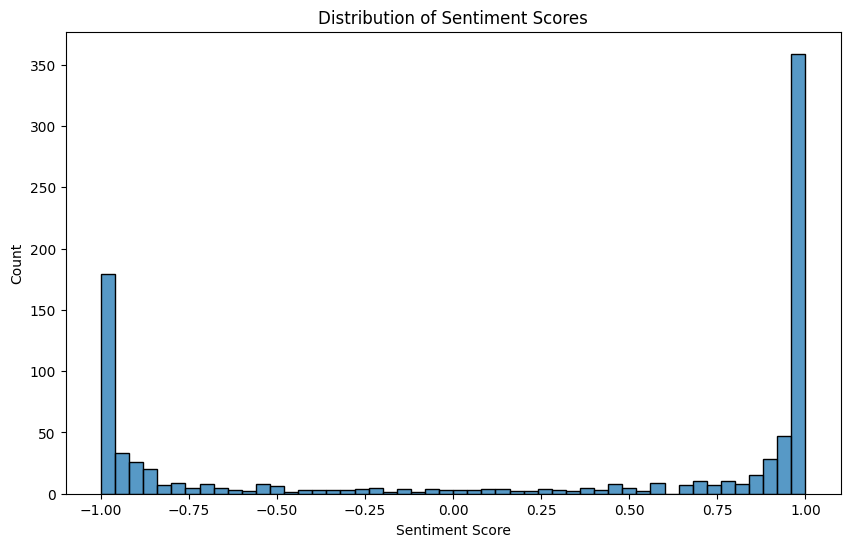

In [791]:
def analyze_sentiment(text):
    """Analyze sentiment using VADER"""
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

df['sentiment'] = df['cleaned_text'].apply(lambda x: analyze_sentiment(x)['compound'])
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')


df['sentiment_summary'] = df['cleaned_summary'].apply(lambda x: analyze_sentiment(x)['compound'])
df['sentiment_label_summary'] = df['sentiment_summary'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

df['sentiment_title'] = df['cleaned_title'].apply(lambda x: analyze_sentiment(x)['compound'])
df['sentiment_label_title'] = df['sentiment_title'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment', bins=50)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()



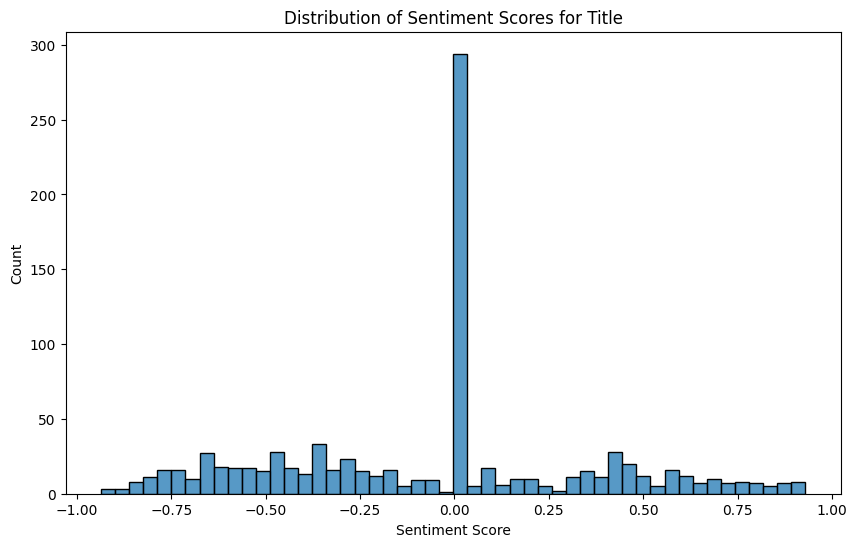

In [792]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment_title', bins=50)
plt.title('Distribution of Sentiment Scores for Title')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

In [793]:
pivot_table = df.pivot_table(index='sentiment_label', 
                             columns='sentiment_label_title', 
                             aggfunc='size', 
                             fill_value=0)

pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100


sentiment_label_title,negative,neutral,positive
sentiment_label,,,
negative,65.306122,25.947522,8.746356
neutral,50.000000,16.666667,33.333333
positive,23.765996,37.477148,38.756856


In [794]:
sample_article = df[(df['sentiment_label']=='positive')&(df['sentiment_label_title']=='negative')].sample(n=1).squeeze()
print(sample_article['title'])
print(sample_article['full_text'])

German leader is more worried about Musk's backing of a far-right party than his insults
BERLIN (AP) — German Chancellor Olaf Scholz says he's staying “cool” against critical personal comments made by Elon Musk but finds it worrying that the U.S. billionaire makes the effort to get involved in a general election by endorsing the far-right Alternative for Germany (AfD) party. Scholz was reacting after Musk, a close ally to U.S. President-elect Donald Trump, called the chancellor a “fool” after his coalition government collapsed in November and later backed the AfD in an opinion piece he wrote for a major newspaper in Germany. Scholz, head of the Social Democratic Party of Germany (SPD), said in comments published Saturday by the German magazine Stern that there is “nothing new” in criticism by “rich media entrepreneurs who do not appreciate social democratic politics and do not hold back with their opinions.” See for yourself — The Yodel is the go-to source for daily news, entertainment

Interestingly most titles seem to have a score around 0, implying most titles are more neutral. On the other hand, the content of the article was evaluated in the extremes of positive or negative, showing a clear decisive factor.

When we look at the comparison between the label for title and content of the article, we see that most negative articles had a negative title as well (65%). While on the other hand, positive articles had either a positive (38%) or neutral (37.8%) title. There seems to be a 23% articles where the article is considered positive, but the title negative. This discrepancy may show some limitations in the VADER method.

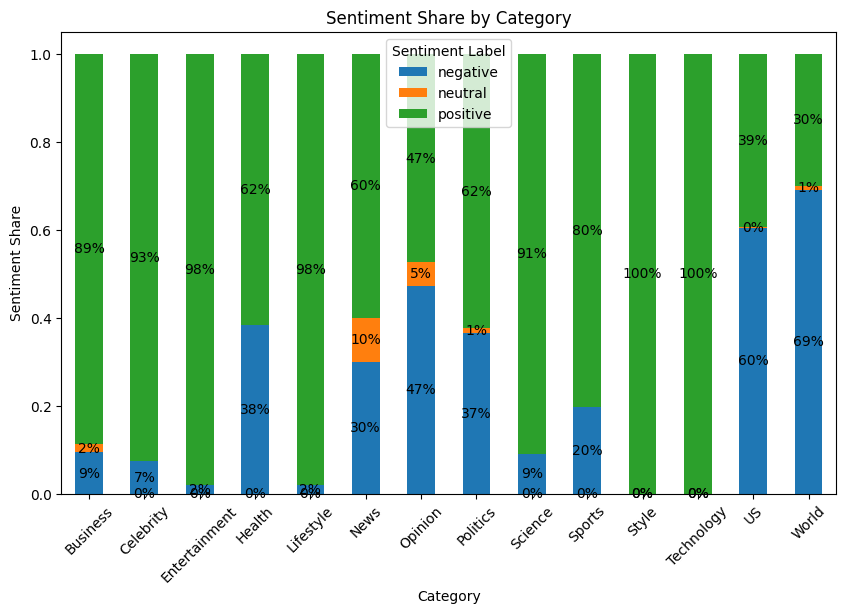

In [795]:
import seaborn as sns
import matplotlib.pyplot as plt


grouped_df = df.groupby(['category_label', 'sentiment_label']).size().unstack()

grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

ax = grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Sentiment Share by Category')
plt.xlabel('Category')
plt.ylabel('Sentiment Share')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Label')
plt.show()

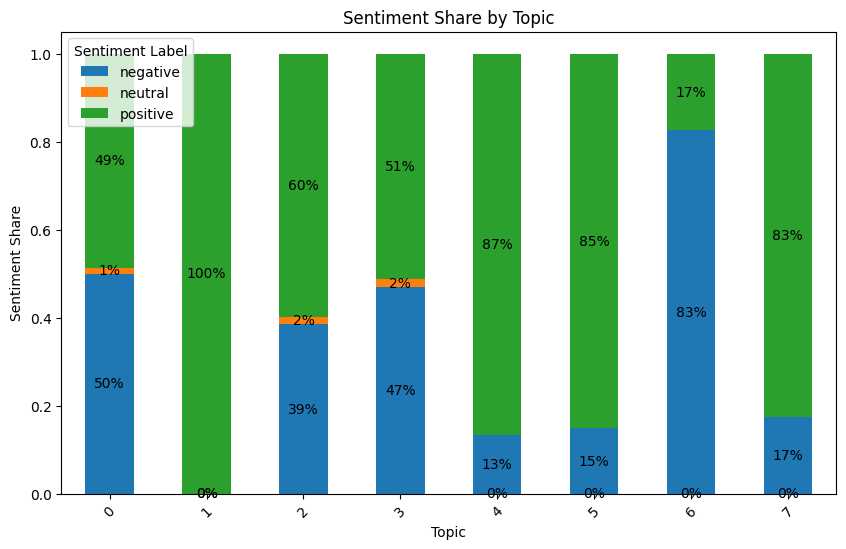

In [796]:
import seaborn as sns
import matplotlib.pyplot as plt


grouped_df = df.groupby(['topic', 'sentiment_label']).size().unstack()

grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

ax = grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Sentiment Share by Topic')
plt.xlabel('Topic')
plt.ylabel('Sentiment Share')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Label')
plt.show()

The categories that display a higher share of negative news are World (69%), US (60%) and Opinion (47%). The Positive ones on the other hand are Style (100%), Technology (100%), Entertaiment (98% positive) and Lifestyle (98%).

On the other hand, when analizing these topics, we notice that the main share of the negative articles is given by topic 6, related to police and crime news. Followed by topic 0 (Health and war in Ukraine) and 3 (weather)

## Word Frequency 

We will analyze the wordcloud for positive and negative articles

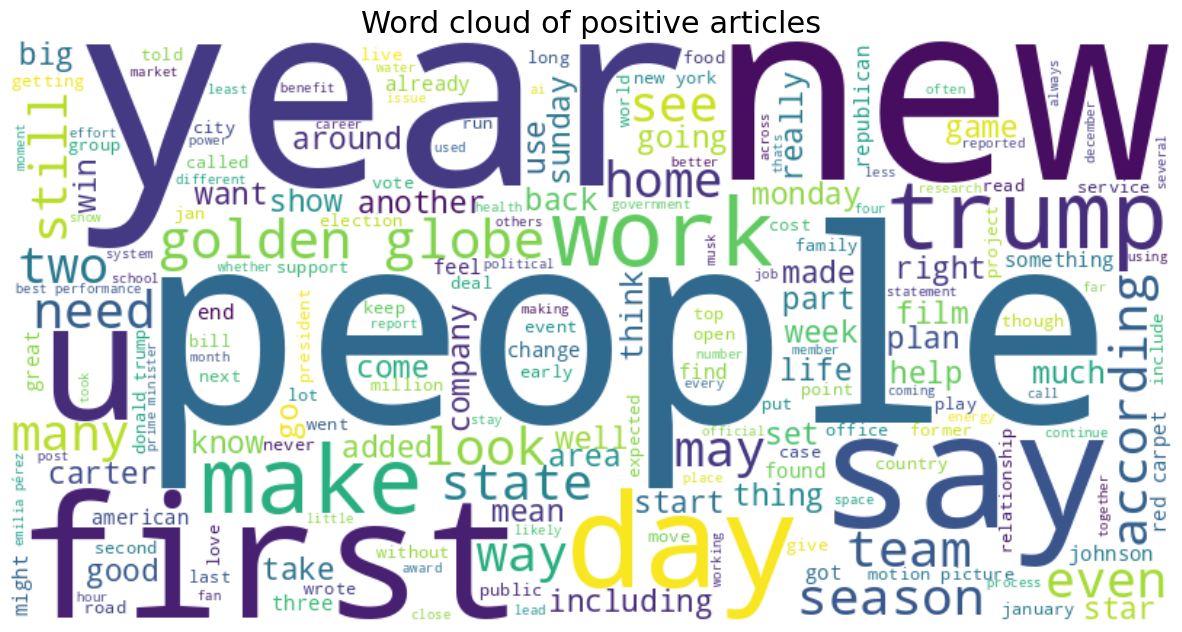

In [797]:
def create_word_cloud(texts, title='Word Cloud of Articles'):
    """Create and display word cloud"""
    all_text = ' '.join(texts)
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=200
    ).generate(all_text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=22)
    plt.show()

create_word_cloud(df[df['sentiment_label']=='positive']['tokens'].apply(lambda x: ' '.join(x)), title='Word cloud of positive articles')


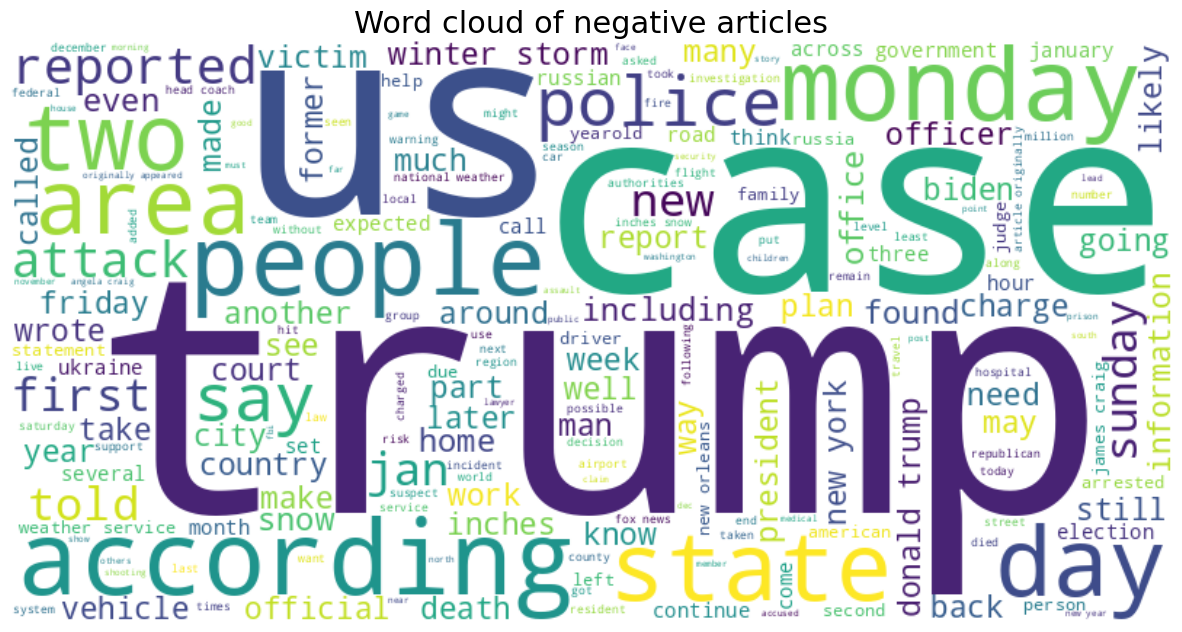

In [798]:
create_word_cloud(df[df['sentiment_label']=='negative']['tokens'].apply(lambda x: ' '.join(x)), title='Word cloud of negative articles')

For positive articles we can see that some words related to sports and celebrations are mentioned. This could be related to teh period of the articles analized (first week of january). Some other words related to films are mentioned as well.

For negative articles, we see words related to bad weather, monday, police and some legal issues.

## Analysis of comment count and other variables

We are interested in exploring which variables affect the number of comments.

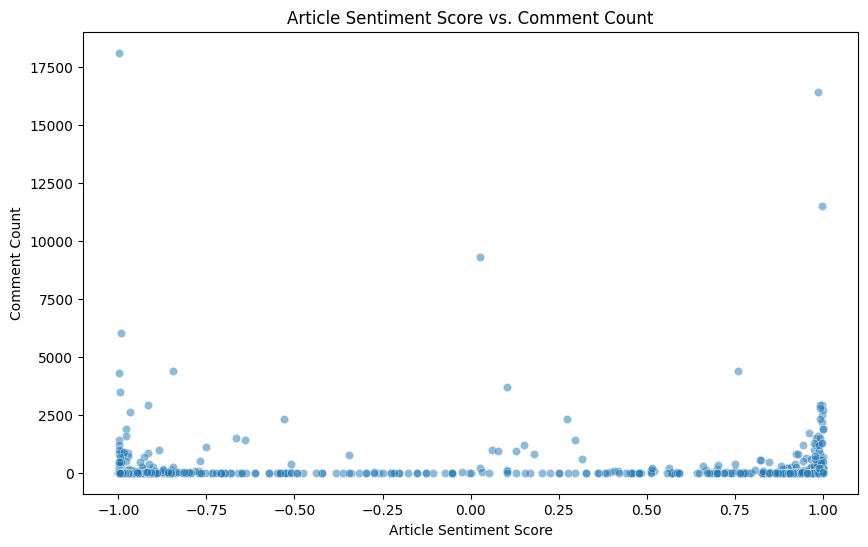

Correlation between comment_count and sentiment: -0.0170


In [799]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sentiment', y='comment_count', alpha=0.5)

plt.title('Article Sentiment Score vs. Comment Count')
plt.ylabel('Comment Count')
plt.xlabel('Article Sentiment Score')

plt.show()


correlation = df[['comment_count', 'sentiment']].corr()
print(f"Correlation between comment_count and sentiment: {correlation.iloc[0,1]:.4f}")

There seems to be no correlation between the sentiment of the article and the number of comments. However, we can see that the comments that are on the extremes of the scores seem to have a higher number of comments. This is not always the case, but we might take this into consideration for further analysis.

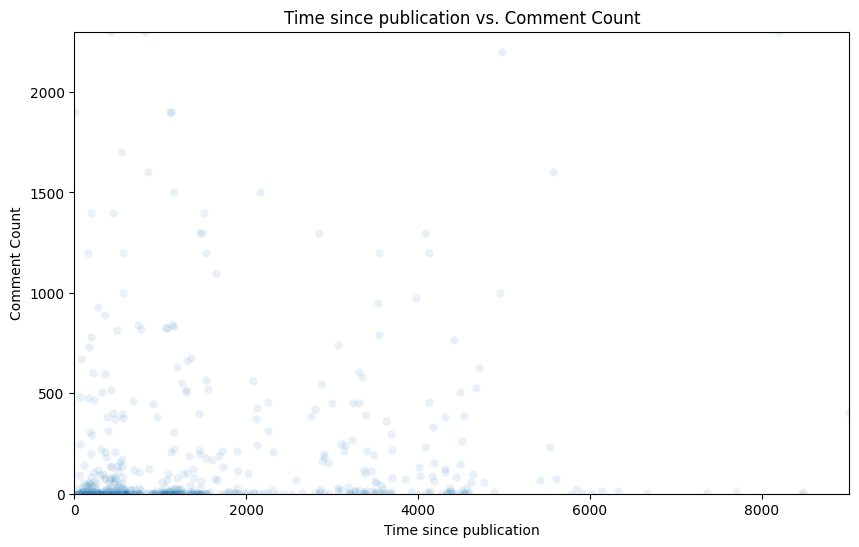

Correlation between comment_count and time_since_publication: 0.2069


In [800]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='time_since_publication', y='comment_count', alpha=0.1)

plt.title('Time since publication vs. Comment Count')
plt.ylabel('Comment Count')
plt.xlabel('Time since publication')
plt.xlim(0, df['time_since_publication'].quantile(0.98))
plt.ylim(0, df['comment_count'].quantile(0.98))
plt.show()


correlation = df[['comment_count', 'time_since_publication']].corr()
print(f"Correlation between comment_count and time_since_publication: {correlation.iloc[0,1]:.4f}")

In [801]:
df.select_dtypes(include='number').corr()

,read_time,comment_count,time_since_publication,title_length,article_length,sentiment,sentiment_summary,sentiment_title
read_time,1.000000,0.199894,0.166814,0.086867,0.878434,0.181678,0.110033,0.124121
comment_count,0.199894,1.000000,0.206914,0.095279,0.190600,-0.016959,-0.006095,-0.039789
time_since_publication,0.166814,0.206914,1.000000,0.161083,0.143379,0.115841,0.082787,0.026937
title_length,0.086867,0.095279,0.161083,1.000000,0.170545,0.106691,0.074476,0.112354
article_length,0.878434,0.190600,0.143379,0.170545,1.000000,0.168241,0.109775,0.126357
sentiment,0.181678,-0.016959,0.115841,0.106691,0.168241,1.000000,0.533380,0.498913
sentiment_summary,0.110033,-0.006095,0.082787,0.074476,0.109775,0.533380,1.000000,0.482019
sentiment_title,0.124121,-0.039789,0.026937,0.112354,0.126357,0.498913,0.482019,1.000000


There is a small correlation between comment count and time since publication, the same applies for the length of the article. 

In [802]:
# export processed data
df.to_csv('processed_news_data.csv', index=False)
print("Exported to 'processed_news_data.csv'")



Exported to 'processed_news_data.csv'


## N-grams

To find out if there are certain words associated to the number of comments let's see teh ngrams

In [812]:
def analyze_ngram_shares(texts, comment_counts, min_appearances=25):
    """
    For each n-gram, calculate what fraction of its appearances are in commented texts.
    """
    vectorizer = CountVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        min_df=5
    )
    
    ngram_matrix = vectorizer.fit_transform(texts)
    ngrams = vectorizer.get_feature_names_out()
    
    results = []
    for i, ngram in enumerate(ngrams):
        # Get which texts contain this n-gram
        presence = ngram_matrix[:, i].toarray().ravel() > 0
        total_appearances = presence.sum()
        
        if total_appearances < min_appearances:
            continue
            
        # Out of texts containing this n-gram, count how many have comments
        texts_with_ngram = presence > 0
        texts_with_comments = comment_counts > 0
        
        # Among texts that have this n-gram...
        commented = (texts_with_ngram & texts_with_comments).sum()    # how many have comments
        uncommented = texts_with_ngram.sum() - commented              # how many don't have comments
        
        # Calculate the ratio: what fraction of texts containing this n-gram have comments?
        ratio = commented / uncommented if uncommented > 0 else float('inf')
        
        results.append({
            'ngram': ngram,
            'ratio': ratio,
            'share_in_commented': commented/texts_with_ngram.sum(),
            'share_in_uncommented': uncommented/texts_with_ngram.sum(),
            'total_appearances': total_appearances
        })
    
    return pd.DataFrame(results).sort_values('ratio', ascending=False)

# Usage
results = analyze_ngram_shares(df['full_text'], df['comment_count'])
results[
    (results['total_appearances'] > 100) & 
    (results['share_in_commented'] > 0.2) & 
    (results['share_in_uncommented'] > 0.1) & 
    ((results['ratio'] > 2) | (results['ratio'] < 0.5))
]

,ngram,ratio,share_in_commented,share_in_uncommented,total_appearances
530,donald trump,4.281250,0.810651,0.189349,169
1314,president elect,3.962963,0.798507,0.201493,134
529,donald,3.888889,0.795455,0.204545,176
1774,trump,3.875000,0.794872,0.205128,195
574,election,3.714286,0.787879,0.212121,132
571,elect,3.176471,0.760563,0.239437,142
1312,president,3.155172,0.759336,0.240664,241
1281,point,2.900000,0.743590,0.256410,117
767,government,2.857143,0.740741,0.259259,135
1891,win,2.656250,0.726496,0.273504,117


# Modeling

In [859]:
bins = [0, 180, 360, 720, 1440, 4320, np.inf]
labels = ['< 3 hour', '< 6 hours', '< 12 hours', '< 1 day', '< 3 days', '> 3 days']

df['time_bucket'] = pd.cut(df['time_since_publication'], 
                          bins=bins, 
                          labels=labels)

df['time_bucket'].astype('str').value_counts()

time_bucket
< 12 hours    210
< 1 day       169
< 3 days      165
< 3 hour      145
< 6 hours     123
> 3 days       67
Name: count, dtype: int64

In [860]:
df['publish_dow'] = (df['publish_date'].dt.dayofweek).astype('category')
df['publish_hour'] = df['publish_date'].dt.hour
df['publish_is_weekend'] = df['publish_date'].dt.dayofweek.isin([5,6])


df['time_bucket'] = df['time_bucket'].astype('category')
df['category_label'] = df['category_label'].astype('category')
df['publisher'] = df['publisher'].astype('str').fillna('Other').astype('category')
df['author'] = df['author'].astype('category')
df['sentiment_label'] = df['sentiment_label'].astype('category')
df['sentiment_label_summary'] = df['sentiment_label_summary'].astype('category')
df['sentiment_label_title'] = df['sentiment_label_title'].astype('category')

df['has_trump'] = df['cleaned_text'].str.contains('trump', case=False, regex=False)
df['has_biden'] = df['cleaned_text'].str.contains('biden', case=False, regex=False)
df['has_president'] = df['cleaned_text'].str.contains('president', case=False, regex=False)

df['has_biden'] = df['cleaned_text'].str.contains('biden', case=False, regex=False)
df['has_fbi'] = df['cleaned_text'].str.contains('fbi', case=False, regex=False)
df['has_attack'] = df['cleaned_text'].str.contains('attack', case=False, regex=False)
df['has_terrorist'] = df['cleaned_text'].str.contains('terrorist', case=False, regex=False)
df['has_orleans'] = df['cleaned_text'].str.contains('new orleans', case=False, regex=False)


df['has_coach'] = df['cleaned_text'].str.contains('coach', case=False, regex=False)
df['has_nfl'] = df['cleaned_text'].str.contains('nfl', case=False, regex=False)
df['has_ukraine'] = df['cleaned_text'].str.contains('ukraine', case=False, regex=False)
df['has_county'] = df['cleaned_text'].str.contains('county', case=False, regex=False)

filtered = df[df['read_time'].notna()]
char_min = (filtered['article_length']/filtered['read_time']).mean()

df['read_time'] = df['read_time'].fillna((df['article_length']/char_min).astype('int'))
df.dropna(subset='comment_count', inplace=True)
df = df[df['comment_count']<10000].reset_index(drop=True)


In [861]:
(df['comment_count']>0).value_counts()/len(df)

comment_count
True     0.567691
False    0.432309
Name: count, dtype: float64

In [862]:
corr_matrix = df[['has_trump', 'has_biden', 'has_president', 'has_fbi', 
                  'has_attack', 'has_terrorist', 'has_orleans', 'has_coach', 'has_nfl', 'has_ukraine', 'has_county']].corr()

print("Correlation Matrix:")
corr_matrix


Correlation Matrix:


,has_trump,has_biden,has_president,has_fbi,has_attack,has_terrorist,has_orleans,has_coach,has_nfl,has_ukraine,has_county
has_trump,1.000000,0.529188,0.717537,0.173634,0.293757,0.123756,0.084261,-0.114661,0.078750,0.126298,-0.122768
has_biden,0.529188,1.000000,0.514857,0.154842,0.204191,0.148494,0.087063,-0.074200,0.032151,0.054182,-0.087359
has_president,0.717537,0.514857,1.000000,0.105285,0.209737,0.075785,0.071877,-0.098780,0.095261,0.214883,-0.162281
has_fbi,0.173634,0.154842,0.105285,1.000000,0.341607,0.213960,0.374563,-0.001595,0.009956,0.014828,-0.027262
has_attack,0.293757,0.204191,0.209737,0.341607,1.000000,0.351689,0.356476,-0.018628,0.035676,0.179653,-0.033294
has_terrorist,0.123756,0.148494,0.075785,0.213960,0.351689,1.000000,0.405969,-0.033317,0.002549,0.065686,-0.019735
has_orleans,0.084261,0.087063,0.071877,0.374563,0.356476,0.405969,1.000000,0.188051,0.169496,0.028318,-0.012764
has_coach,-0.114661,-0.074200,-0.098780,-0.001595,-0.018628,-0.033317,0.188051,1.000000,0.238600,-0.037359,-0.043716
has_nfl,0.078750,0.032151,0.095261,0.009956,0.035676,0.002549,0.169496,0.238600,1.000000,0.124153,-0.128661
has_ukraine,0.126298,0.054182,0.214883,0.014828,0.179653,0.065686,0.028318,-0.037359,0.124153,1.000000,-0.070636


In [863]:
scale_pos_weight = (df['comment_count']>0).sum()/(df['comment_count']==0).sum()

In [864]:
df['comment_count'].describe()

count     879.000000
mean      176.547213
std       612.605732
min         0.000000
25%         0.000000
50%         1.000000
75%        50.000000
max      9300.000000
Name: comment_count, dtype: float64

In [865]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score, f1_score, mean_absolute_error, mean_squared_error
import warnings
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


warnings.filterwarnings("ignore")

target_variable = "comment_count"
drop_cols = ['comment_count','url', 'title', 'summary', 'full_text', 'publish_date', 'updated_at', 'created_at', 'cleaned_text', 'cleaned_summary', 'cleaned_title', 'tokens', 'tokens_summary', 'tokens_title']
feature_names = df.columns.drop([target_variable]+drop_cols)


categorical_features = df[feature_names].select_dtypes(
        include=['category', 'object']).columns.tolist()

numeric_features = df[feature_names].select_dtypes(
        include=['int32', 'int64', 'float32', 'float64', 'Int64']).columns.tolist()

boolean_features = df[feature_names].select_dtypes(include=['bool']).columns.tolist()


# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder( sparse_output=False, handle_unknown='ignore', min_frequency=10, max_categories=20))
        ]), categorical_features)
    ],
    remainder='passthrough'
)



# Create classification pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('classifier', XGBClassifier(
        objective='binary:logistic', # binary:logistic, binary:hinge, 
        #scale_pos_weight=scale_pos_weight,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        enable_categorical=False
    ))
], verbose=True)


# Prepare features and target
X = df[numeric_features + categorical_features + boolean_features]
y = df['comment_count']

# has_trump	has_biden	has_president	has_fbi
# Split the data
threshold = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['time_bucket'].astype('str')+(df['comment_count']>0).astype('str'), random_state=42)

# Train binary classifier

y_binary_train = (y_train > threshold).astype(int)
y_binary_test = (y_test > threshold).astype(int)


In [867]:
y_binary_train.value_counts()/len(y_binary_train)

comment_count
1    0.567568
0    0.432432
Name: count, dtype: float64

In [868]:
y_binary_test.value_counts()/len(y_binary_test)

comment_count
1    0.568182
0    0.431818
Name: count, dtype: float64

In [869]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

def classification_metric(Y_real, Y_pred):

    acc = accuracy_score(Y_real, Y_pred)
    precision = precision_score(Y_real, Y_pred)
    recall = recall_score(Y_real, Y_pred)
    f1 = f1_score(Y_real, Y_pred)
    roc = roc_auc_score(Y_real, Y_pred)
    
    metrics = pd.DataFrame({'accuracy' : [acc], 
                            'precision':[precision],
                            'recall':[recall],
                            'ROC':[roc], 
                            'F1': [f1]
                           })
    return metrics


def display_confusion_matrix(Y_real, y_pred):
    cm = confusion_matrix(Y_real, y_pred)
    
    TN = cm[0][0] 
    TP = cm[1][1] 
    FP = cm[0][1] 
    FN = cm[1][0] 
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    group_counts = ['{:,.0f}'.format(value) for value in
                    cm.flatten()]
    
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')
    plt.title('Confusion Matrix: \n Has comments: levels: Yes No', fontsize = 10) 
    plt.xlabel('', fontsize = 15) 
    plt.ylabel('', fontsize = 15)
    
    print("Sum of TP + TN + FP + FN = ", str(TP) + " + " + str(TN) + " + " +str(FP)+ " + "+ str(FN), " = " + str(TP+TN+FP+FN))
    print(len(Y_real) == TP+TN+FP+FN)


In [870]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, loguniform, norm
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")


# Define parameter distributions
clf_param_dist = {
    'classifier__n_estimators': randint(100, 500),  # Narrowed range, usually >500 trees don't help much
    'classifier__max_depth': randint(4, 8),         # Narrowed to prevent overfitting
    'classifier__learning_rate': uniform(0.01, 0.19), # Lower learning rates often work better
    'classifier__subsample': uniform(0.7, 0.3),     # Centered around 0.85 which often works well
    'classifier__colsample_bytree': uniform(0.7, 0.3),  
    'classifier__min_child_weight': randint(1, 6),  # Smaller range is usually sufficient
    'classifier__gamma': loguniform(1e-3, 1.0),     # Log-uniform for gamma often works better
    'classifier__reg_alpha': [0, 0.001, 0.01, 0.1, 1.0],  # Log-scale values
    'classifier__reg_lambda': [0.01, 0.1, 1.0, 10.0],     # Log-scale values
    #'classifier__scale_pos_weight': loguniform(0.4, 5.0)
    #'classifier__scale_pos_weight': norm(loc=1.31, scale=0.3)
    'classifier__scale_pos_weight': uniform(0.6, 1.6),  # Centered around 1.31
    # 'classifier__scale_pos_weight': uniform(1.0, 1.6),  # Centered around 1.31
    #'classifier__scale_pos_weight': uniform(0.6, 1.0),  # Centered around 0.76
}


from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Perform Randomized Search for classifier
print("Performing Randomized Search for classifier...")
clf_random_search = RandomizedSearchCV(
    clf_pipeline,
    clf_param_dist,
    n_iter=300,
    cv=cv,
    scoring='f1', #f1, precision
    n_jobs=-1,
    random_state=42
)

clf_random_search.fit(X_train, y_binary_train)



Performing Randomized Search for classifier...
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.2s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['read_time',
                                                                                'time_since_publication',
                                                                                'title_length',
                                                                                'article_length',
                                                                                'sentiment',
                                                                                'sentiment...
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x335e89350>,
                                        'classifier__reg_alpha': [0, 0.001,
                                                                  0.01, 0.1,
                                                                  1.0],
                                        'classifier__reg_lambda': [0.01, 0.1,
                                                                   1.0, 10.0],
                                        'classifier__scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3311580d0>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x328f385d0>},
                   random_state=42, scoring='f1')


Best classifier parameters: {'classifier__colsample_bytree': 0.9172855924379235, 'classifier__gamma': 0.1768010815082242, 'classifier__learning_rate': 0.03772519406667764, 'classifier__max_depth': 7, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 145, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 10.0, 'classifier__scale_pos_weight': 1.1536265082317434, 'classifier__subsample': 0.9327414207378868}

Classification Metrics:
AUC-ROC: 0.822
F1-Score: 0.804
Precision: 0.771
Recall: 0.840
Train


,accuracy,precision,recall,ROC,F1
0,0.914651,0.926952,0.922306,0.913456,0.924623


Test:


,accuracy,precision,recall,ROC,F1
0,0.767045,0.770642,0.84,0.755526,0.803828


Sum of TP + TN + FP + FN =  84 + 51 + 25 + 16  = 176
True


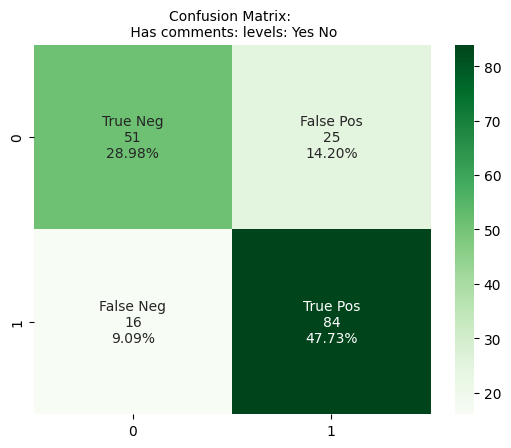

In [871]:
# Print best parameters
print("\nBest classifier parameters:", clf_random_search.best_params_)


# Make predictions with best models
binary_pred_train = clf_random_search.predict(X_train)
binary_pred_test = clf_random_search.predict(X_test)
binary_pred_prob_test = clf_random_search.predict_proba(X_test)[:, 1]

# Evaluate with extended metrics
print("\nClassification Metrics:")
print(f"AUC-ROC: {roc_auc_score(y_binary_test, binary_pred_prob_test):.3f}")
print(f"F1-Score: {f1_score(y_binary_test, binary_pred_test):.3f}")
print(f"Precision: {precision_score(y_binary_test, binary_pred_test):.3f}")
print(f"Recall: {recall_score(y_binary_test, binary_pred_test):.3f}")


from sklearn.metrics import confusion_matrix,accuracy_score

y_pred_train = clf_random_search.predict(X_train)
y_pred_test = clf_random_search.predict(X_test)


print("Train")
display(classification_metric(y_binary_train, y_pred_train))

print("Test:")
display(classification_metric(y_binary_test, y_pred_test))


display_confusion_matrix(y_binary_test, y_pred_test)

In [876]:
# Get indices of false positives
false_positive_indices = np.where((y_binary_test == 0) & (binary_pred_test == 1))[0]

# Create a DataFrame with false positives
false_positives_df = pd.DataFrame(X_test.iloc[false_positive_indices])
true_negatives_df = pd.DataFrame(X_test.iloc[np.where((y_binary_test == 0) & (binary_pred_test == 0))[0]])


In [873]:
# Create indices for all quadrants of confusion matrix
fp_indices = np.where((y_binary_test == 0) & (binary_pred_test == 1))[0]  # False Positives
tn_indices = np.where((y_binary_test == 0) & (binary_pred_test == 0))[0]  # True Negatives
tp_indices = np.where((y_binary_test == 1) & (binary_pred_test == 1))[0]  # True Positives
fn_indices = np.where((y_binary_test == 1) & (binary_pred_test == 0))[0]  # False Negatives

# Create DataFrames for each quadrant
fp_df = pd.DataFrame(X_test.iloc[fp_indices])
tn_df = pd.DataFrame(X_test.iloc[tn_indices])
tp_df = pd.DataFrame(X_test.iloc[tp_indices])
fn_df = pd.DataFrame(X_test.iloc[fn_indices])



bins = [0, 60, 360, 720, 1440, 10080, 43200,]
labels = ['< 1 hour', '< 6 hours', '< 12 hours',  '< 1 day', '< 1 week', '< 1 month']


for bucket in [fp_df, tn_df, tp_df, fn_df]:
    bucket['time_bucket'] = pd.cut(bucket['time_since_publication'], 
                              bins=bins, 
                              labels=labels)



Text(0, 0.5, 'Minutes')

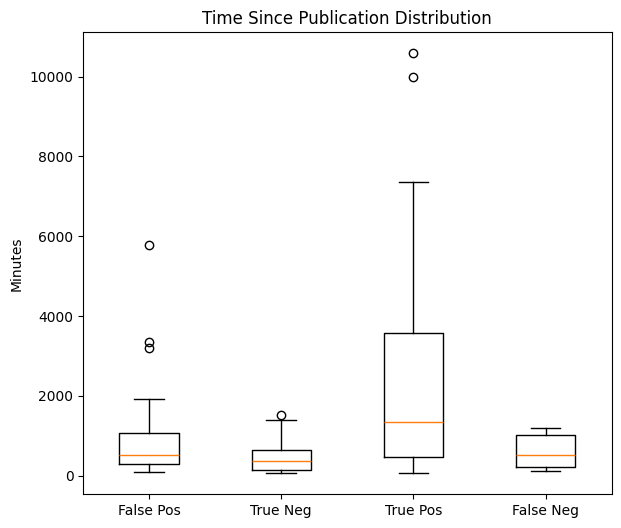

In [874]:
# Visualize distributions
plt.figure(figsize=(15, 6))

# Boxplot for time distribution
plt.subplot(1, 2, 1)
plt.boxplot([fp_df['time_since_publication'], 
             tn_df['time_since_publication'],
             tp_df['time_since_publication'], 
             fn_df['time_since_publication']], 
            labels=['False Pos', 'True Neg', 'True Pos', 'False Neg'])
plt.title('Time Since Publication Distribution')
plt.ylabel('Minutes')



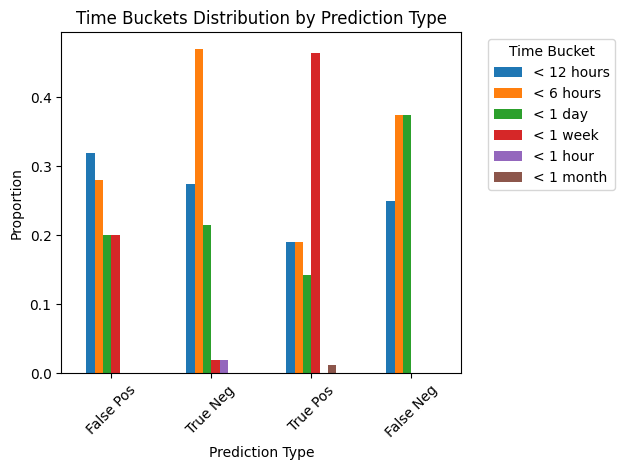

In [875]:
# Bar plot for time buckets
#plt.subplot(1, 2, 2)
quadrants = ['False Pos', 'True Neg', 'True Pos', 'False Neg']
data = [fp_df['time_bucket'].value_counts(normalize=True),
        tn_df['time_bucket'].value_counts(normalize=True),
        tp_df['time_bucket'].value_counts(normalize=True),
        fn_df['time_bucket'].value_counts(normalize=True)]

time_dist_df = pd.DataFrame(data, index=quadrants)
time_dist_df.plot(kind='bar')
plt.title('Time Buckets Distribution by Prediction Type')
plt.xlabel('Prediction Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Time Bucket', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [836]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


reg_param_dist = {
    'regressor__objective': ['reg:squaredlogerror'], 
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(4, 8),
    'regressor__learning_rate': uniform(0.01, 0.19),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
    'regressor__min_child_weight': randint(1, 6),
    'regressor__gamma': loguniform(1e-3, 1.0),
    'regressor__reg_alpha': [0, 0.001, 0.01, 0.1, 1.0],
    'regressor__reg_lambda': [0.01, 0.1, 1.0, 10.0]    
}


# Perform Randomized Search for regressor
print("\nPerforming Randomized Search for regressor...")
mask_train = y_train > 0
y_train_reg = np.log1p(y_train[mask_train])


# Create regression pipeline
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror', # reg:squarederror, reg:quantileerror, reg:absoluteerror, reg:pseudohubererror, reg:squaredlogerror
        #quantile_alpha=0.5,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


reg_random_search = RandomizedSearchCV(
    reg_pipeline,
    reg_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error', # neg_mean_squared_error, neg_root_mean_squared_error, neg_mean_absolute_percentage_error
    n_jobs=-1,
    random_state=42
)
reg_random_search.fit(X_train[mask_train], y_train_reg)


Performing Randomized Search for regressor...


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['read_time',
                                                                                'time_since_publication',
                                                                                'title_length',
                                                                                'article_length',
                                                                                'sentiment',
                                                                                'sentiment_summary',
                                                                                'sentiment_title',
                                                                                'publish_hour']),
                                                                              ('cat',
                                                                               Pip...
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x302b5a750>,
                                        'regressor__objective': ['reg:squaredlogerror'],
                                        'regressor__reg_alpha': [0, 0.001, 0.01,
                                                                 0.1, 1.0],
                                        'regressor__reg_lambda': [0.01, 0.1,
                                                                  1.0, 10.0],
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x314e43450>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [877]:
print("Best regressor parameters:", reg_random_search.best_params_)

# For regression predictions
final_predictions = np.zeros(len(X_test))
pred_mask = binary_pred_test > 0 # use classifier
if pred_mask.sum() > 0:
    log_pred = reg_random_search.predict(X_test[pred_mask])
    final_predictions[pred_mask] = np.expm1(log_pred)


print("\nRegression Metrics")

print(f"MAE: {mean_absolute_error(y_test, final_predictions):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, final_predictions)):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, final_predictions):.3f}%")



Best regressor parameters: {'regressor__colsample_bytree': 0.7755346887476092, 'regressor__gamma': 0.03102740950912839, 'regressor__learning_rate': 0.06716687886518624, 'regressor__max_depth': 4, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 286, 'regressor__objective': 'reg:squaredlogerror', 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 0.1, 'regressor__subsample': 0.8508037069686584}

Regression Metrics
MAE: 110.288
RMSE: 457.064
MAPE: 207.828%


In [880]:
# Get feature names from the fitted model
preprocessor = clf_grid_search.best_estimator_.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()

top_n = 15
# Get most important features for each model

clf_feat_imp = pd.DataFrame({
    'feature': transformed_feature_names,
    'importance': clf_importance
}).sort_values('importance', ascending=False)
    

reg_preprocessor = reg_grid_search.best_estimator_.named_steps['preprocessor']
reg_transformed_feature_names = reg_preprocessor.get_feature_names_out()

reg_feat_imp = pd.DataFrame({
    'feature': reg_transformed_feature_names,
    'importance': reg_importance
}).sort_values('importance', ascending=False)


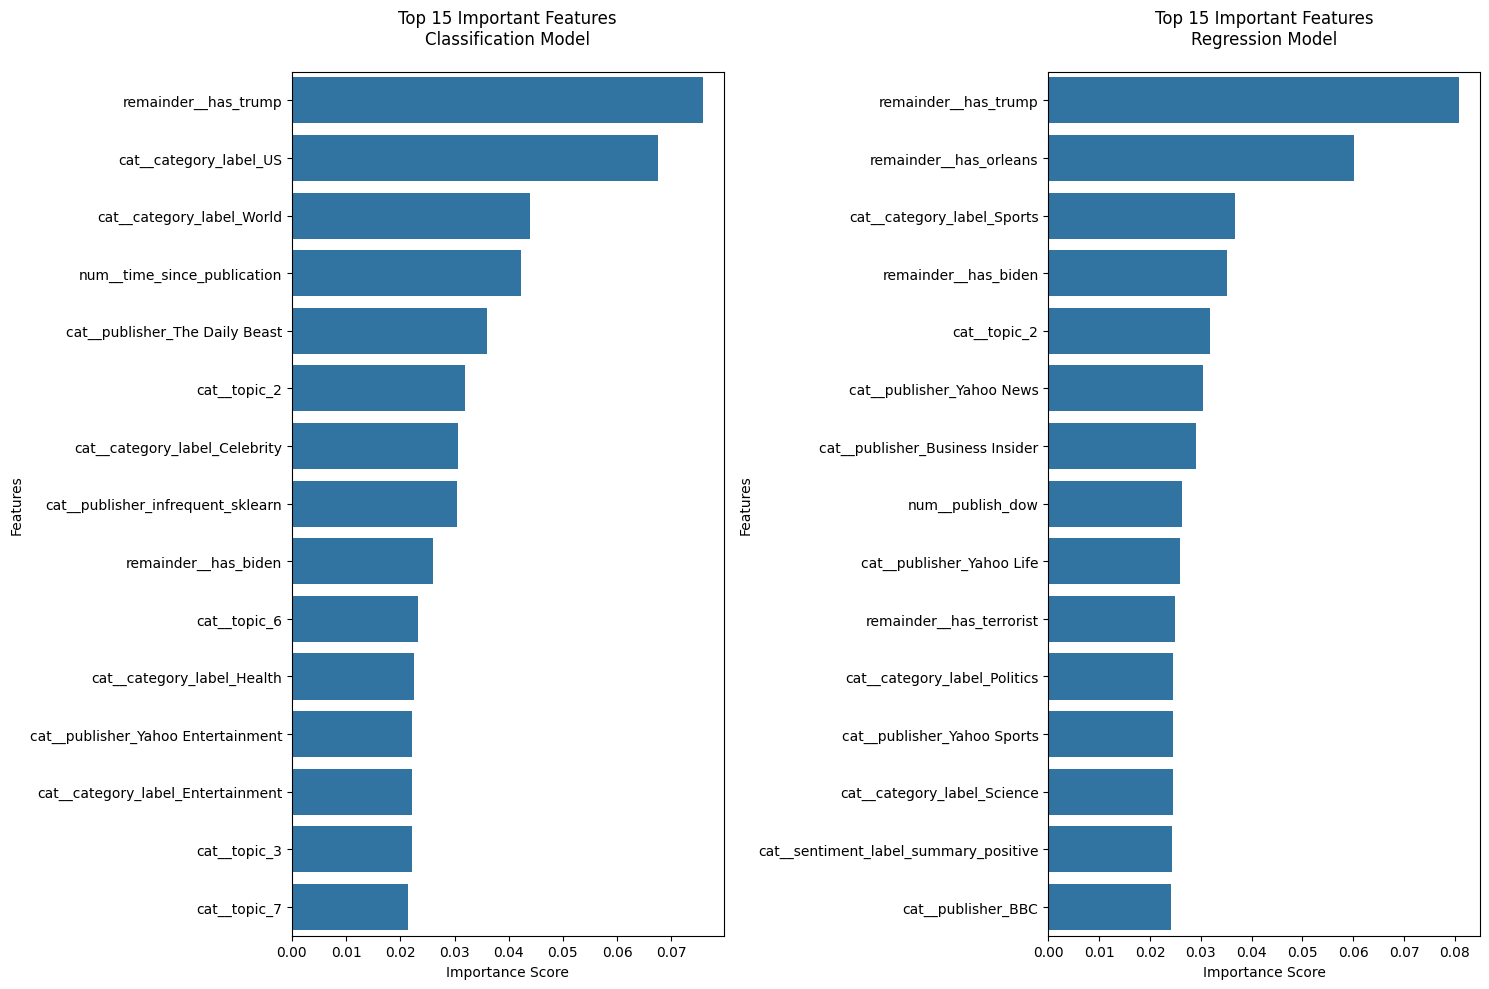

In [881]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
sns.barplot(data=clf_feat_imp.head(top_n), x='importance', y='feature')
plt.title('Top 15 Important Features\nClassification Model', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('Features')


plt.subplot(1, 2, 2)
sns.barplot(data=reg_feat_imp.head(top_n), x='importance', y='feature')
plt.title('Top 15 Important Features\nRegression Model', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('Features')


plt.tight_layout()
plt.show()


# Summary

We managed to find some new topics that were not covered by the categories, opening the posibility to analyze and further explore these topics when it comes to sentiment analysis. While we did not manage to explain the number of comments using sentiment, we found other variables that might contribute to a higher number of comments.

When predicting wether an article has comments or not, some of the most important features were captured thanks to text mining, including wether the text contains the word `trump` or it belongs to `topic_2` (election and politics) or `topic_6` (police, crime news). Other extracted features, specially related to sentiment analysis didn't seem to have such an importance.
